<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Final/Grid_Test_Knock_In_Call_3stocks_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [1]:
import pandas as pd

In [2]:
nstock = 3
model_save_name = f'jax_knock_in_{str(nstock)}stocks_v2.pth'

# Dataset generation

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import cupy
# import jax
# import jax.numpy as jnp
# from jax import random
# from jax import jit
# import numpy as np
# import pandas as pd
# from torch.utils.dlpack import from_dlpack

# def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
#     stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
#     stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
#                             jax.ops.index[0],         # initialization of stock prices
#                             initial_stocks)
#     noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
#     sigma = jnp.diag(cov) ** 0.5
#     dt = T / numsteps
#     def time_step(t, val):
#         dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
#         val = jax.ops.index_update(val,
#                             jax.ops.index[t],
#                             val[t-1] * dx)
#         return val
#     return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

# def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
#     out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
#     knock_in_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
#     r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_in_index]/(knock_in_index+1)

#     return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
#                     (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_in_index] - K) *   # (S[knock-in]-K)
#                     jnp.exp(- r_mean_array * (T * (knock_in_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

# goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

# #################################################################### Adjust all parameters here (not inside class)
# numstocks = 3
# numsteps = 50
# numpaths = 2000000

# rng = jax.random.PRNGKey(np.random.randint(10000))
# rng, key = jax.random.split(rng)
# keys = jax.random.split(key, numpaths)

# S1_range = jnp.linspace(0.75, 1.25, 6)[2:4]
# S2_range = jnp.linspace(0.75, 1.25, 6)
# S3_range = jnp.linspace(0.75, 1.25, 6)
# K_range = jnp.linspace(0.75, 1.25, 5)
# B_range = jnp.linspace(1.1, 1.6, 6)
# sigma_range = jnp.linspace(0.15, 0.45, 3)
# r_range = jnp.linspace(0.01, 0.04, 3)
# T = 1.0

# fast_simple = jax.jit(Brownian_motion, static_argnums=2)
# batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
# ####################################################################

# call = []
# count = 0

# for S1 in S1_range:
#   for S2 in S2_range:
#     for S3 in S3_range:
#       for K in K_range:
#         for B in B_range:
#           for r in r_range:
#             for sigma in sigma_range:

#               initial_stocks = jnp.array([S1, S2, S3]) # must be float
#               r_tmp = jnp.array([r]*numsteps)
#               drift = jnp.array([r]*numstocks)
#               cov = jnp.identity(numstocks)*sigma*sigma

#               Knock_In_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)
#               Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)
#               call.append([T, K, B, S1, sigma, r, r,
#                           T, K, B, S2, sigma, r, r,
#                           T, K, B, S3, sigma, r, r, Knock_In_Call_price] + list(Deltas)) #T, K, B, S, sigma, mu, r, price, delta
              
#               count += 1
#               print(count)


# Thedataset = pd.DataFrame(call)

# #save to csv
# Thedataset.to_csv(f'/content/drive/MyDrive/AFP/Save_Models/Knock_In_Call_{str(nstock)}stocks_Datset_part{part}.csv', index=False, header=False)

# Access to the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read csv
Thedataset = pd.read_csv(f'/content/drive/MyDrive/Grid Datasets/Knock_In_Call_{str(nstock)}stocks_Datset_v2.csv', header=None)

# Construct Neural Net

In [6]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:7*nstock]
Thedataset_Y = Thedataset.iloc[:,7*nstock:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# print
# ds = OptionDataSet(max_len = 1)
# for i in ds:
#     print(i[0])
#     print(i[0].shape)
#     print(i[1])
#     print(i[1].shape)

In [3]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024, nstock = 1):
        self.nstock = nstock
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*self.nstock, 128) # remember to change this!
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, nstock + 1) # outputs: prices, delta
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.5, 0.3, 0.03, 0.03] * self.nstock)) # don't use numpy here - will give error later
                                                                               # T, K, B, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 1.1, 0.75, 0.15, 0.01, 0.01] * self.nstock).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [8]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 5.0 MB/s 


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net(nstock = nstock).cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 200) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    # def compute_deltas(x):
    #   inputs = x.float()
    #   inputs.requires_grad = True
    #   first_order_gradient = grad(model(inputs), inputs, create_graph=False)
    #   return first_order_gradient[0][[3]]  # Now index 3 is stock price, not 2

    # deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    # y_pred = torch.cat((y_pred, deltas), 1)
    # # print(y_pred)
    # # print(y_pred.shape)

    loss_weight = torch.tensor([1] * (nstock+1)).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 50

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 1000)

# model_save_name = f'jax_knock_out_{str(nstock)}stocks_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  """


loss 0.0018644846994297756 average time 0.01966405685999689 iter num 50
loss 0.0017438497339167596 average time 0.018001443389999566 iter num 100
loss 0.0016934007509133665 average time 0.017422853273333393 iter num 150
loss 0.0016820084239677134 average time 0.017136152350000627 iter num 200
loss 0.0014745300462280044 average time 0.016252658860000792 iter num 50
loss 0.0012599690646884318 average time 0.01627961663000036 iter num 100
loss 0.0011283136824367201 average time 0.016271886180000857 iter num 150
loss 0.0010995102438741506 average time 0.01627311143500094 iter num 200
loss 0.0006854609700514705 average time 0.016260971379999774 iter num 50
loss 0.0004987725577148031 average time 0.016251355069999817 iter num 100
loss 0.0004534097933127426 average time 0.016247772199999795 iter num 150
loss 0.0004466004732420434 average time 0.016253411854999057 iter num 200
loss 0.00038038853585186755 average time 0.016260832280000272 iter num 50
loss 0.00034976296163554375 average time 0.0

**Save Model**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import torch
# model_save_name = f'jax_knock_out_{str(nstock)}stocks_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import torch
# model_save_name = f'jax_knock_out_{str(nstock)}stocks_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [8]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net(nstock = nstock).cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=21, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=4, bias=True)
)


**Continue to train model**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net(nstock = nstock).cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3, eps=1e-4, amsgrad=True) # try using higher epsilon and amsgrad
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x.float())

    loss_weight = torch.tensor([1] * (nstock+1)).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 50

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 500)

path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

#Results

In [9]:
# Knock in call
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    knock_in_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
    r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_in_index]/(knock_in_index+1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_in_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_in_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 3
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

K = 1.0
T = 1.0
r = 0.02
sigma = 0.25
B = 1.15
initial_stocks = jnp.array([1.]*numstocks) # must be float
r_tmp = jnp.array([r]*numsteps)
drift = jnp.array([r]*numstocks)
cov = jnp.identity(numstocks)*sigma*sigma

fast_simple = jax.jit(Brownian_motion, static_argnums=2)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
# print(optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)) # here numsteps different from T

# delta
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)) # here numsteps different from T

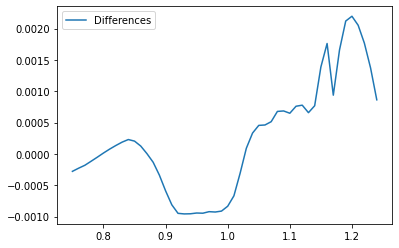

In [11]:
import matplotlib.pyplot as plt
import numpy as np

B = 1.15

def compute_price(S):
    inputs = torch.tensor([[1, 1, B, S, 0.25, 0.02, 0.02] * 3]).cuda()
    return model(inputs.float())[0][0]

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
correct_call_prices = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_prices.append(compute_price(p).item())
    correct_call_prices.append(optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, correct_call_prices, label = "JAX_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(correct_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

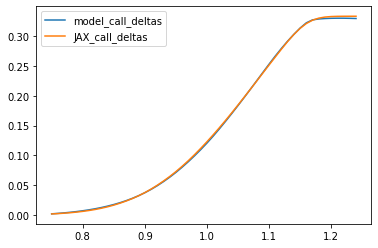

In [12]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.15

def compute_delta(S):
    inputs = torch.tensor([[1, 1, B, S, 0.25, 0.02, 0.02] * 3]).cuda()
    return model(inputs.float())[0][2]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)[1])
plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

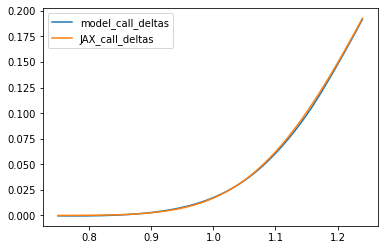

In [13]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.35

def compute_delta(S):
    inputs = torch.tensor([[1, 1, B, S, 0.25, 0.02, 0.02] * 3]).cuda()
    return model(inputs.float())[0][2]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)[1])
plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

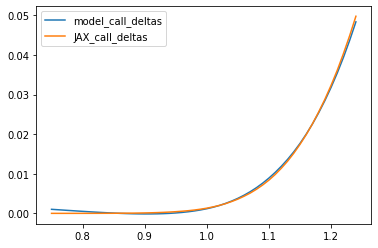

In [14]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.55

def compute_delta(S):
    inputs = torch.tensor([[1, 1, B, S, 0.25, 0.02, 0.02] * 3]).cuda()
    return model(inputs.float())[0][2]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)[1])
plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

# Comparison on speed

In [20]:
%timeit goptionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, 0.75, B, T, numpaths)
%timeit compute_delta(1).item()

10 loops, best of 5: 889 ms per loop
The slowest run took 1191.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 619 µs per loop


# Heat Map

In [30]:
import pandas as pd
import numpy as np
import cupy

df = pd.DataFrame(np.zeros((25,10)))
df.columns = np.around(np.linspace(0.005, 0.05, 10), 3)
df.index = np.around(np.arange(0.77, 1.27, 0.02), 2)

for col_num,approx_width in enumerate(df.columns):
  base = []
  approx = [] # approximated value calculated from base
  model_value = [] # value given by model
  for S in df.index:
    inputs = torch.tensor([[1, 1, 1.15, S - approx_width, 0.25, 0.02, 0.02] + [1, 1, 1.15, S - approx_width, 0.25, 0.02, 0.02] + [1, 1, 1.15, S - approx_width, 0.25, 0.02, 0.02]]).cuda()
    base.append(model(inputs.float())[0][0])
    approx.append(model(inputs.float())[0][0] + ((model(inputs.float())[0][1:]) * approx_width).sum())
    inputs2 = torch.tensor([[1, 1, 1.15, S, 0.25, 0.02, 0.02] + [1, 1, 1.15, S, 0.25, 0.02, 0.02] + [1, 1, 1.15, S, 0.25, 0.02, 0.02]]).cuda()
    model_value.append(model(inputs2.float())[0][0])
  abs_error = (np.absolute(np.array(approx)-np.array(model_value))).astype(float)
  df.iloc[:,col_num] = abs_error

df

,0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.045,0.050
0.77,0.000098,0.000194,0.000288,0.000378,0.000465,0.000548,0.000626,0.000700,0.000769,0.000832
0.79,0.000137,0.000273,0.000405,0.000535,0.000660,0.000782,0.000899,0.001012,0.001119,0.001220
0.81,0.000186,0.000369,0.000550,0.000727,0.000901,0.001070,0.001234,0.001393,0.001546,0.001693
0.83,0.000250,0.000498,0.000741,0.000979,0.001212,0.001440,0.001662,0.001878,0.002088,0.002291
0.85,0.000294,0.000597,0.000910,0.001229,0.001542,0.001848,0.002145,0.002434,0.002714,0.002986
0.87,0.000349,0.000705,0.001069,0.001439,0.001814,0.002194,0.002578,0.002964,0.003339,0.003703
0.89,0.000409,0.000836,0.001278,0.001728,0.002182,0.002638,0.003094,0.003551,0.004008,0.004465
0.91,0.000546,0.001081,0.001610,0.002145,0.002690,0.003244,0.003805,0.004367,0.004927,0.005481
0.93,0.000745,0.001503,0.002253,0.002987,0.003703,0.004400,0.005081,0.005760,0.006440,0.007121
0.95,0.000830,0.001694,0.002589,0.003514,0.004468,0.005426,0.006366,0.007280,0.008167,0.009025


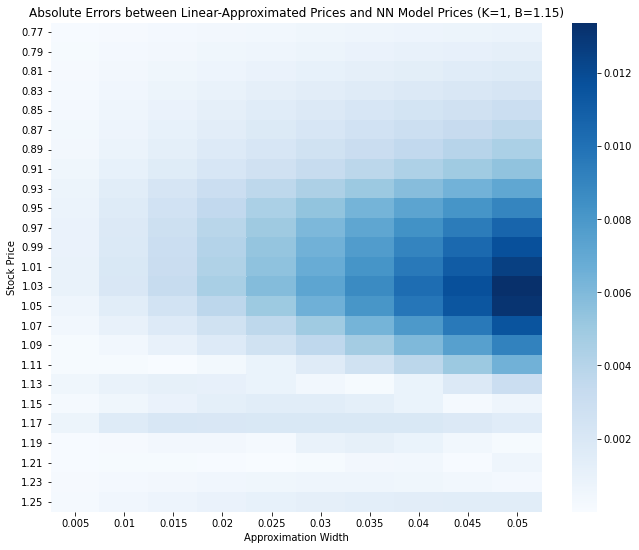

In [31]:
import matplotlib.pyplot as plt
import seaborn as sb
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(df, cmap='Blues')
plt.title('Absolute Errors between Linear-Approximated Prices and NN Model Prices (K=1, B=1.15)')
plt.xlabel('Approximation Width')
plt.ylabel('Stock Price')
plt.show()